In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch  import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

%matplotlib inline

In [2]:
from sklearn.datasets import make_multilabel_classification

In [3]:
X, y = make_multilabel_classification(n_samples=20000, n_features=1024, n_classes=8, random_state=1)
X.shape, y.shape

((20000, 1024), (20000, 8))

In [4]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [5]:
for i in range(10):
  print(X[i], y[i]) # This is how the data looks. Just an overview

[0. 1. 0. ... 0. 1. 0.] [1 1 0 0 0 0 0 0]
[0. 0. 0. ... 0. 1. 0.] [1 1 0 0 0 0 1 0]
[0. 0. 0. ... 0. 0. 0.] [1 0 0 1 0 0 0 1]
[0. 0. 0. ... 0. 0. 0.] [1 0 0 0 0 0 1 0]
[0. 0. 0. ... 0. 0. 0.] [1 1 0 0 0 0 0 1]
[0. 0. 0. ... 1. 1. 0.] [1 0 0 1 0 0 0 1]
[0. 0. 0. ... 0. 0. 0.] [0 0 0 0 0 0 0 0]
[0. 0. 0. ... 0. 0. 0.] [0 0 0 0 0 0 0 0]
[0. 0. 0. ... 0. 0. 0.] [0 1 0 0 0 0 0 0]
[0. 0. 0. ... 0. 0. 0.] [1 1 0 0 0 0 0 1]


In [6]:
class TabDataSet(Dataset):
  def __init__(self, features, targets):
    self.x = features
    self.y  = targets
  def __len__(self): return len(self.x)
  def __getitem__(self, idx): return self.x[idx], self.y[idx]

In [7]:
def get_dataloader(features, targets, bs):
  X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state=42)

  #DataSets
  train_ds = TabDataSet(X_train, y_train)
  test_ds = TabDataSet(X_test, y_test)

  #DataLoader
  train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
  test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True)

  return train_dl, test_dl

In [8]:
scalar = StandardScaler()
X = scalar.fit_transform(X)

In [9]:
bs= 256 #batch size
train_dl, test_dl = get_dataloader(X, y, bs)

In [10]:
def first(x):
  "First element of `x`, or None if missing"
  try: return next(iter(x))
  except StopIteration: return None

In [11]:
xb, yb  = first(train_dl)
xb.shape, yb.shape

(torch.Size([256, 1024]), torch.Size([256, 8]))

In [12]:
def get_model(n_in, n_out):
  return nn.Sequential(nn.Linear(n_in, 512), 
                       nn.ReLU(),
                       nn.Linear(512, 256), 
                       nn.ReLU(),
                       nn.Linear(256, 128), 
                       nn.ReLU(),
                       nn.Linear(128, 64),
                       nn.ReLU(),
                       nn.Linear(64, 32),
                       nn.ReLU(),
                       nn.Linear(32, 16), 
                       nn.ReLU(),
                       nn.Linear(16,n_out))

In [13]:
model  = get_model(1024, 8)
model

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=32, bias=True)
  (9): ReLU()
  (10): Linear(in_features=32, out_features=16, bias=True)
  (11): ReLU()
  (12): Linear(in_features=16, out_features=8, bias=True)
)

In [14]:
def loss_func(inputs, targets):
  loss = nn.BCEWithLogitsLoss()
  return loss(inputs, targets.float()) 

In [15]:
def validate_epoch(model, metric):
  accs = [metric(model(xb.float()), yb) for xb,yb in test_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [16]:
def accuracy_multilabel(xb, yb, tresh=0.42):
  preds = torch.sigmoid(xb)
  correct = (preds > tresh) == yb.bool()
  return correct.float().mean()

In [17]:
def train_model(model, epochs, metric):
  for i  in range(epochs):
    for xb, yb in train_dl:
      preds = model(xb.float())
      loss = loss_func(preds, yb)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    print(validate_epoch(model, metric), end=" ")

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_model(model, 5, metric=accuracy_multilabel)

0.7654 0.7872 0.8103 0.8211 0.8186 

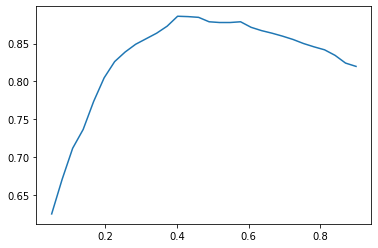

In [19]:
xs = torch.linspace(0.05,  0.9, 30)
preds  = model(xb.float())
accs = [accuracy_multilabel(preds, yb, tresh=i)  for i in xs]
plt.plot(xs, accs)

In [25]:
test_data = X[6]
out_predict = model(torch.tensor(test_data).float())
out_predict.argmax()

tensor(1)

In [26]:
y[6]

array([0, 0, 0, 0, 0, 0, 0, 0])